- LSTM forecast pipeline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


C:\Users\rafae\AppData\Local\Temp\ipykernel_10684\1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


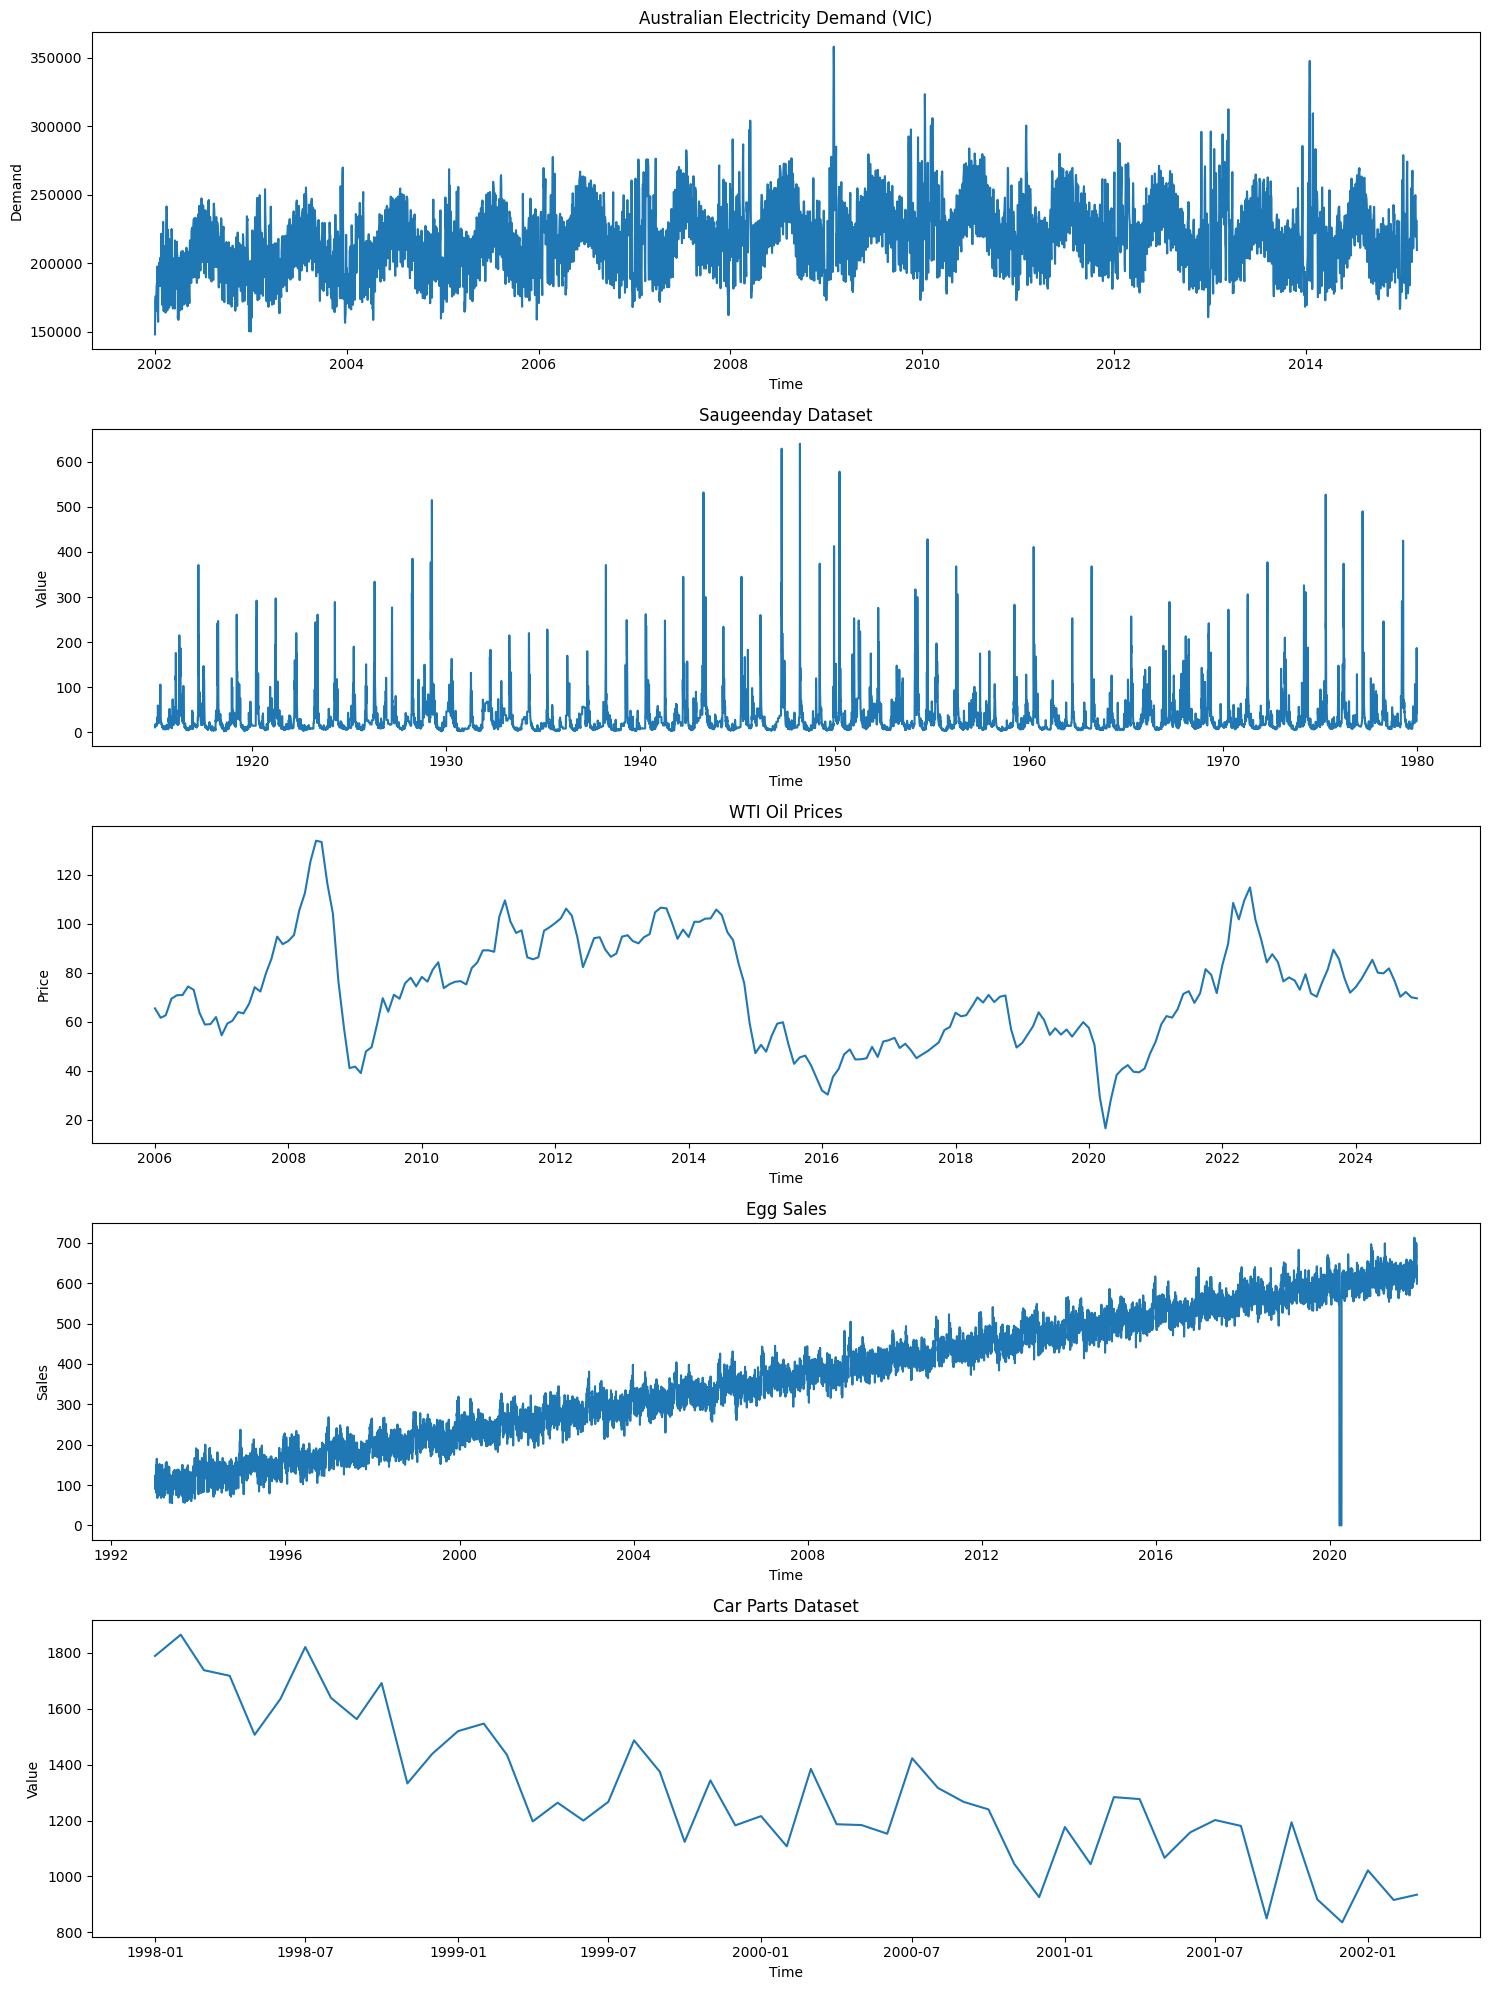

In [12]:
%run datagetter.ipynb
%run basic_functions.ipynb

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def calc_forecast_metrics(y_true, y_pred):
    """Return MAE, MAPE, RMSE in a dictionary for model evaluation."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse}

def lstm_forecast(train_df, test_df, lookback=14, lstm_units=64, dropout=0.2, epochs=20, batch_size=32, figsize=(14, 6)):
    # Combine for scaling
    data = pd.concat([train_df, test_df], ignore_index=True)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data['y'].values.reshape(-1, 1))

    # Prepare sequences
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i-lookback:i, 0])
        y.append(scaled[i, 0])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Map indices to train/test
    split_idx = len(train_df) - lookback
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Build and train LSTM
    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Dates for plotting (test only, aligns with y_pred/y_test)
    test_dates = test_df['ds'].iloc[:len(y_test_true)]

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
    plt.plot(test_df['ds'].iloc[:len(y_test_true)], y_test_true, label='Test Data', color='green')
    plt.plot(test_df['ds'].iloc[:len(y_pred)], y_pred, label='LSTM Forecast', color='darkorange')
    plt.axvline(test_df['ds'].iloc[0], color='tab:red', linestyle='--', label='Train/Test Split')
    plt.title('LSTM Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics
    metrics = calc_forecast_metrics(y_test_true, y_pred)
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print(f"RMSE: {metrics['RMSE']:.2f}")

    # Return model, predictions and metrics (optionally also y_pred, y_test_true)
    return model, pd.DataFrame({'ds': test_dates, 'y_true': y_test_true, 'y_pred': y_pred}), metrics


==== WTI Oil ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


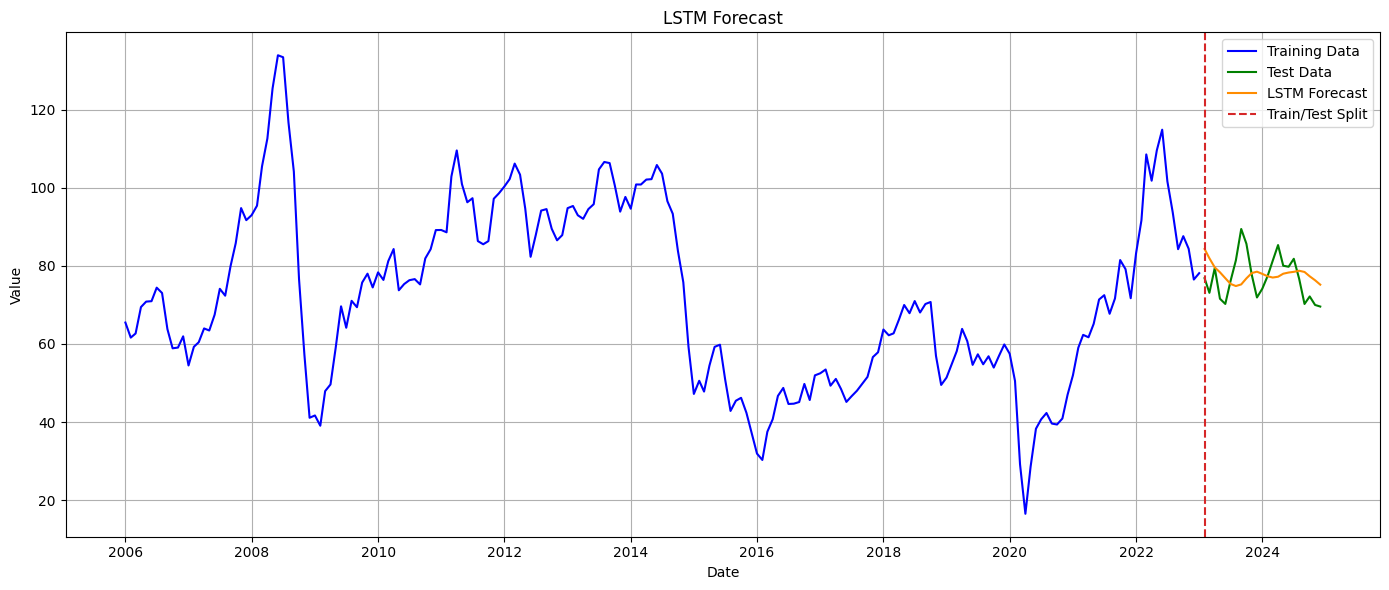

MAE: 5.11
MAPE: 6.65%
RMSE: 6.17
==== Saugeen River ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


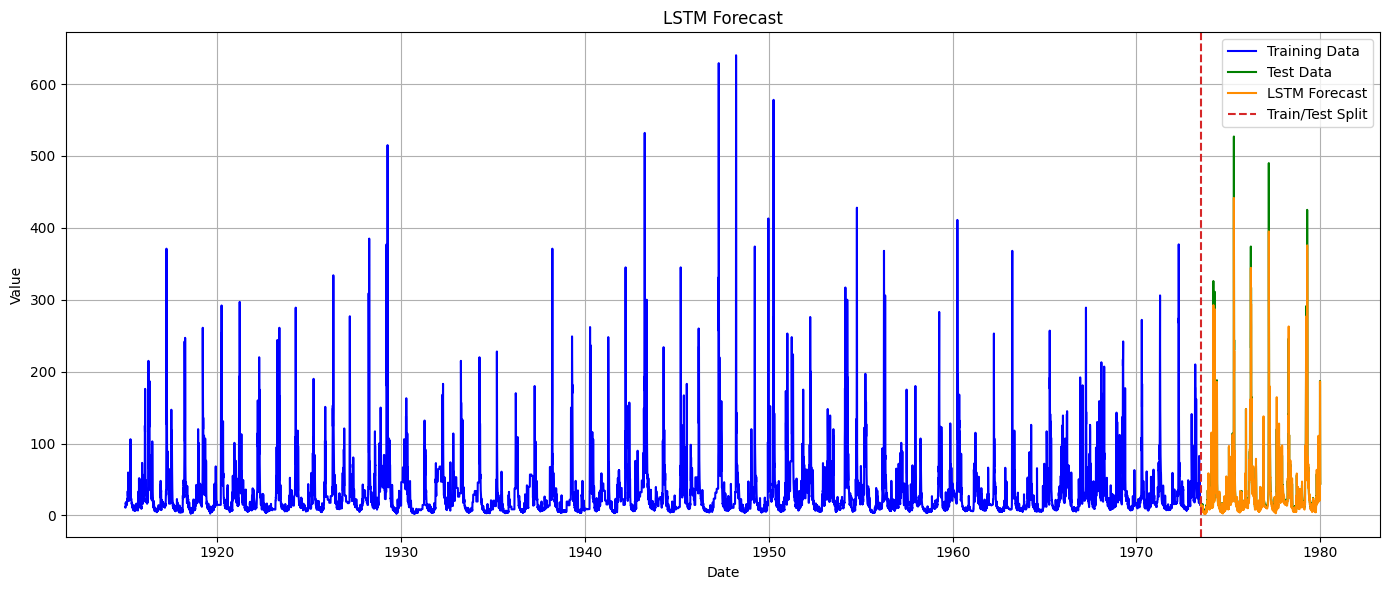

MAE: 5.18
MAPE: 18.57%
RMSE: 12.71
==== Egg Sales ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


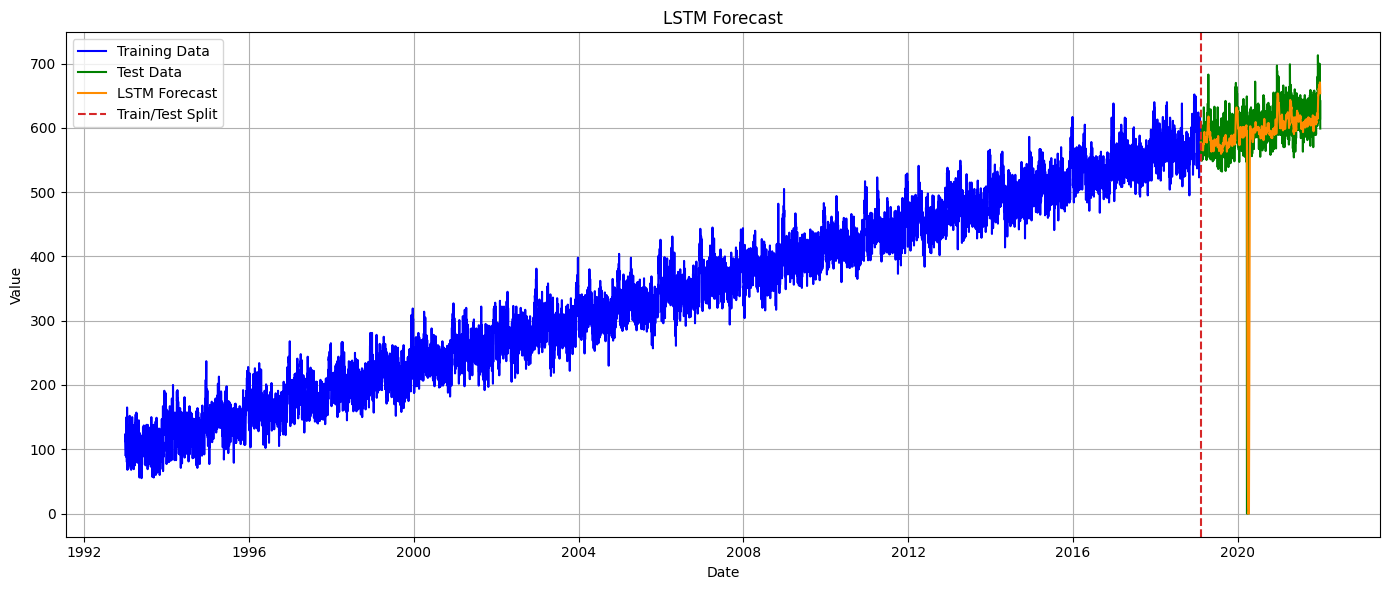

MAE: 23.89
MAPE: 3.55%
RMSE: 50.81
==== Australian Electricity Demand ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


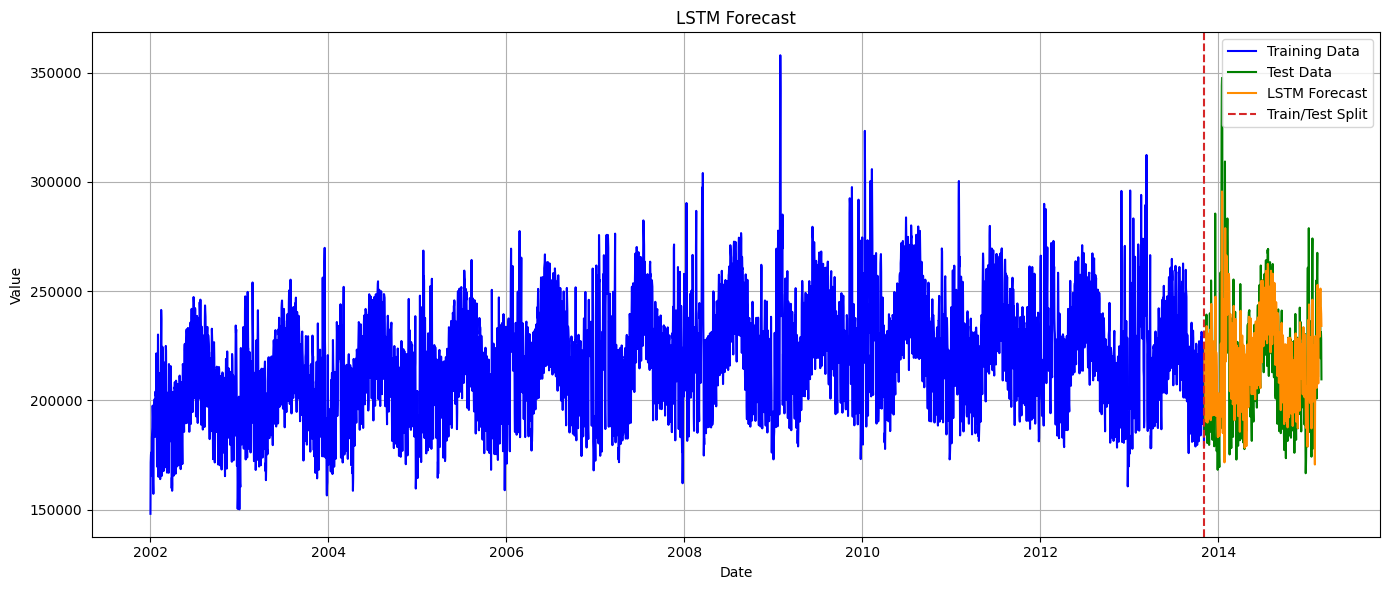

MAE: 11777.72
MAPE: 5.39%
RMSE: 16542.91
==== Car Parts ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


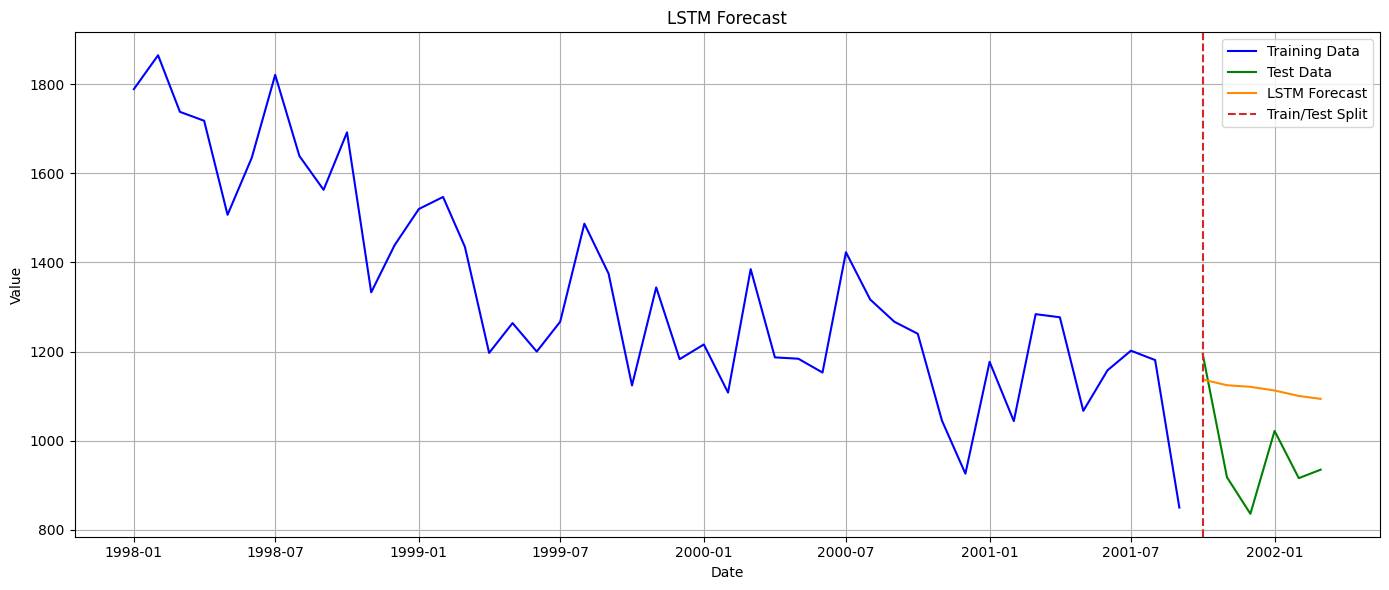

MAE: 163.70
MAPE: 17.89%
RMSE: 180.07


In [14]:
datasets = [
    wti_oil_df,
    saugeen_river_df,
    egg_sales_df,
    australian_electricity_demand_df,
    car_parts_df
]

dataset_names = [
    "WTI Oil",
    "Saugeen River",
    "Egg Sales",
    "Australian Electricity Demand",
    "Car Parts"
]

results = {}

for name, df in zip(dataset_names, datasets):
    train_df, test_df = split_train_test(df, test_size=0.1)
    print(f"==== {name} ====")
    model, forecast, metrics = lstm_forecast(train_df, test_df)
    results[name] = {"model": model, "forecast": forecast, "metrics": metrics}


----------------------------------------------------------------------------------------------------------------